In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm.auto import trange, tqdm

2024-09-23 09:08:54.576475: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 09:08:55.256683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 09:08:55.256811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 09:08:55.382105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 09:08:55.608111: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Carregando o dataset Fashion MNIST
(X_treino, y_treino), (X_teste, y_teste) = tf.keras.datasets.mnist.load_data()
# Normalizando as imagens para o intervalo [-1, 1]
X_treino = (X_treino / 127.5) - 1.0

# Adicionando um canal extra para as imagens de 28x28
X_treino = np.expand_dims(X_treino, axis=-1)

In [3]:
IMG_SIZE = 28     # Tamanho das imagens de entrada, Fashion MNIST é 28x28
BATCH_SIZE = 128  # Tamanho do lote para treinamento
timesteps = 16    # Quantidade de passos para uma imagem ruidosa se tornar clara
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace para timesteps

In [4]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

In [5]:
def show_examples(x):
    num_images = x.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(25, num_images)):  # Mostra no máximo 25 imagens
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img.squeeze(), cmap='gray')  # Exibe como imagem em escala de cinza
        plt.axis('off')

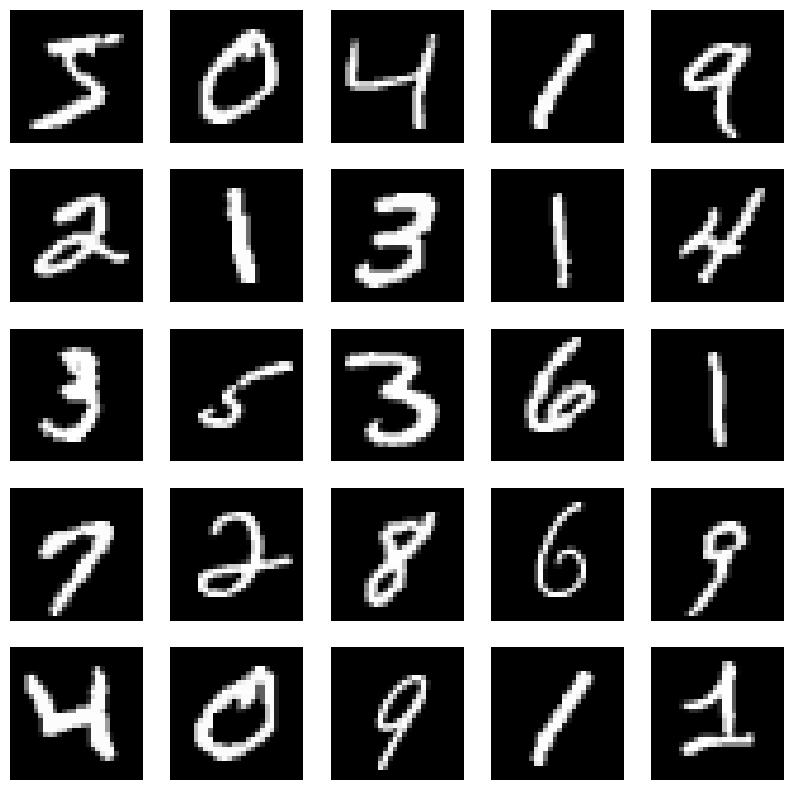

In [6]:
show_examples(X_treino)

In [7]:
def forward_noise(x, t):
    a = time_bar[t]      # imagem no tempo t
    b = time_bar[t + 1]  # imagem em t + 1

    ruido = np.random.normal(size=x.shape)  # Gera máscara de ruído
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + ruido * a
    img_b = x * (1 - b) + ruido * b
    return img_a, img_b

In [8]:
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

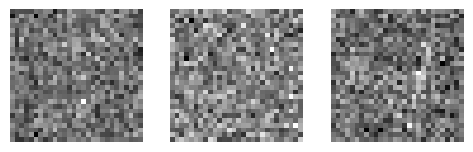

In [9]:
# Gera exemplos de treino
t = generate_ts(3)  # Gera timesteps para 25 exemplos
a, b = forward_noise(X_treino[:3], t)
show_examples(a)

In [10]:
def block(x, x_ts):
    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [11]:
def make_model():
    # Ajuste na entrada para Fashion MNIST
    x = x_input = layers.Input(shape=(28, 28, 1), name='x_input')

    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)

    # ----- left ( down ) -----
    x = x28 = block(x, x_ts)  # 28x28 -> 28x28
    x = layers.MaxPool2D(2, padding='same')(x)  # 28x28 -> 14x14

    x = x14 = block(x, x_ts)  # 14x14 -> 14x14
    x = layers.MaxPool2D(2, padding='same')(x)  # 14x14 -> 7x7

    x = x7 = block(x, x_ts)  # 7x7 -> 7x7
    x = layers.MaxPool2D(2, padding='same')(x)  # 7x7 -> 4x4

    x = x4 = block(x, x_ts)  # 4x4 -> 4x4

    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(4 * 4 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((4, 4, 32))(x)

    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 4x4 -> 8x8

    # Ajuste para 7x7
    x = layers.Cropping2D(((0, 1), (0, 1)))(x)  # 8x8 -> 7x7

    x = layers.Concatenate()([x, x7])
    x = block(x, x_ts)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7 -> 14x14

    x = layers.Concatenate()([x, x14])
    x = block(x, x_ts)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)  # 14x14 -> 28x28

    x = layers.Concatenate()([x, x28])
    x = block(x, x_ts)

    # ----- output -----
    x = layers.Conv2D(1, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

In [12]:
model = make_model()

In [18]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008))

In [13]:
def predict(model, timesteps=50, batch_size=32):
    # Inicialize com ruído gaussiano
    x = np.random.normal(size=(batch_size, 28, 28, 1))

    for i in trange(timesteps):
        t = np.full((batch_size, 1), i)  # Tempo como um vetor coluna
        x = model.predict([x, t], verbose=0)

    # Normalize as imagens para o intervalo [0, 1]
    x = (x - x.min()) / (x.max() - x.min())

    show_examples(x)

In [14]:
def predict_step(model, timesteps=50, num_samples=8):
    xs = []
    x = np.random.normal(size=(num_samples, 28, 28, 1))  # Ajustado para Fashion MNIST

    for i in trange(timesteps):
        t = np.full((num_samples, 1), i)  # Tempo como vetor coluna
        x = model.predict([x, t], verbose=0)
        if i % 5 == 0:  # Salva a cada 5 passos para reduzir o número de imagens
            xs.append(x[0])

    # Normaliza as imagens para o intervalo [0, 1]
    xs = [(x - x.min()) / (x.max() - x.min()) for x in xs]

    plt.figure(figsize=(20, 3))
    for i, img in enumerate(xs):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(img), cmap='gray')
        plt.title(f'Step {i*5}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [16]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_treino[np.random.randint(len(X_treino), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [19]:

train()
# reduce learning rate for next training
#model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

# show result
predict(model)
predict_step(model)

  0%|          | 0/50 [00:00<?, ?it/s]